In [27]:
import pandas as pd
import math
import psycopg2
import psycopg2.extras
from matplotlib import pyplot as plt
import numpy as np
from itertools import product

In [28]:
# Split preprocessed data into n partitions
# Using just the train dataset of census data
#Reference: https://www.geeksforgeeks.org/how-to-create-multiple-csv-files-from-existing-csv-file-using-pandas/ 

def partition_data(n):
    data = pd.read_csv("./data/adult_preprocessed.csv")
    split_file_size = math.ceil(data.shape[0] / n)
    for i in range(n):
        df = data[split_file_size*i:split_file_size*(i+1)]
        df.to_csv(f'./data/adult_{i+1}.csv', index=False)
partition_data(10)

In [32]:
# connect to postgresql database
con = psycopg2.connect("dbname='my_seedb' user='postgres' host='localhost' password=''")
cur = con.cursor()

In [33]:
def create_views(con, cursor):
    user_defined_query = "create view married as select * from census where marital_status in (' Married-AF-spouse', ' Married-civ-spouse', ' Married-spouse-absent',' Separated');"
    reference_query = "create view unmarried as select * from census where marital_status in (' Never-married', ' Widowed',' Divorced');"
    cursor.execute(user_defined_query)
    cursor.execute(reference_query)
    con.commit()
    
# Call method create_views() to create target and reference views
create_views(con, cur) 

In [34]:
# Method to visualize plots
# Reference - https://www.geeksforgeeks.org/plotting-multiple-bar-charts-using-matplotlib-in-python/
def draw_graphs(target_data, ref_data, view_tuple):
    dimension, measure, aggr_func = view_tuple
    target_values = target_data.values()
    ref_values = ref_data.values()
    print('Dimension - {}, measure - {}, aggregate function - {}'.format(dimension, measure, aggr_func))
    
    fig, ax = plt.subplots()
    index = np.arange(len(target_data))
    width = 0.4
    plt.bar(index, target_values, width=width, color='y',label='married')
    plt.bar(index + width, ref_values, width=width, color='c', label='unmarried')

    plt.xlabel('{}'.format(dimension))
    plt.ylabel('{}({})'.format(aggr_func, measure))
    plt.xticks(index + width, target_data.keys(), rotation=45)
    plt.legend()
    plt.show()

Dimension - sex, measure - capital_gain, aggregate function - AVG


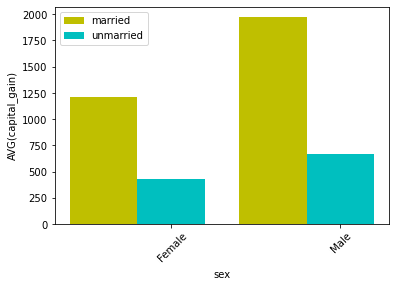

Dimension - sex, measure - age, aggregate function - AVG


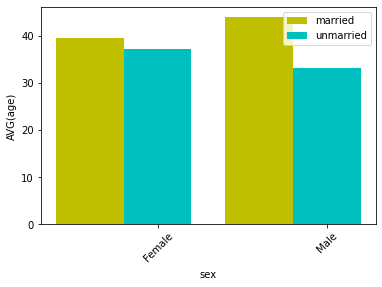

In [35]:
# Reproducing graphs on Figure 1 in the paper
# Average capital gain group by sex for the target data
target_view_query_1 = "SELECT sex, avg(capital_gain) as avg_capital_gain FROM married GROUP BY sex;"
cur.execute(target_view_query_1)
target_data_1 = cur.fetchall()

#print(target_data_1)

# Average capital gain group by sex for the reference data
reference_view_query_1 = "SELECT sex, avg(capital_gain) as avg_cap_gain FROM unmarried GROUP BY sex;"
cur.execute(reference_view_query_1)
reference_data_1 = cur.fetchall()

# Average age group by sex for the target data
target_view_query_2 = "SELECT sex, avg(age) as avg_age FROM married GROUP BY sex;"
cur.execute(target_view_query_2)
target_data_2 = cur.fetchall()

# Average age group by sex for the reference data
reference_view_query_2 = "SELECT sex, avg(age) as avg_age FROM unmarried GROUP BY sex;"
cur.execute(reference_view_query_2)
reference_data_2 = cur.fetchall()

amf_values_1 = ('sex', 'capital_gain', 'AVG')
amf_values_2 = ('sex', 'age', 'AVG')
draw_graphs(dict(target_data_1), dict(reference_data_1), amf_values_1)
draw_graphs(dict(target_data_2), dict(reference_data_2), amf_values_2)

In [36]:
def sharing_based_optimization(views, tables):
    # Implementation of 'Combine multiple aggregates' technique and 'multiple group by' in section 4.1 of the paper
    dimensions = []
    measures = []
    group_by = []
    for i, (f, m, a) in views.items():
        dimensions.append('{}'.format(a))
        #print(dimensions)
        measures.append('{}({}) as v{}'.format(f, m, i))
        #group_by.append('({})'.format(a))
        group_by.append('{}'.format(a))
        #print(group_by)

    select_dimensions = ', '.join(set(dimensions))
    select_measures = ', '.join(measures)
    group_by = ', '.join(set(group_by))

    rows = []
    for table in tables:
        query = """select {}, {} from {} group by grouping sets ({});""".format(select_dimensions, select_measures, table, group_by)
        cur.execute(query)
        rows.append(cur.fetchall())
    #print(cur.description)
    columns = [desc[0] for desc in cur.description]
    print(columns)
    return rows, columns

In [38]:
aggr_funcs = ["avg", "sum", "min", "max", "count"]
dimensions = ["workclass", "education", "occupation", "relationship", "race", "sex", "native_country", "economic_indicator"]
measures = ["age", "education_num", "hours_per_week", "capital_gain", "capital_loss"]

total_views = {k: v for k,v in enumerate(list(product(aggr_funcs, measures, dimensions)))}
print('Total number of visualizations: {}'.format(len(total_views)))

Total number of visualizations: 200


In [39]:
# Apply sharing_based optimization
tables = ['married', 'unmarried']
rows, cols = sharing_based_optimization(total_views, tables)

['native_country', 'education', 'relationship', 'sex', 'economic_indicator', 'occupation', 'race', 'workclass', 'v0', 'v1', 'v2', 'v3', 'v4', 'v5', 'v6', 'v7', 'v8', 'v9', 'v10', 'v11', 'v12', 'v13', 'v14', 'v15', 'v16', 'v17', 'v18', 'v19', 'v20', 'v21', 'v22', 'v23', 'v24', 'v25', 'v26', 'v27', 'v28', 'v29', 'v30', 'v31', 'v32', 'v33', 'v34', 'v35', 'v36', 'v37', 'v38', 'v39', 'v40', 'v41', 'v42', 'v43', 'v44', 'v45', 'v46', 'v47', 'v48', 'v49', 'v50', 'v51', 'v52', 'v53', 'v54', 'v55', 'v56', 'v57', 'v58', 'v59', 'v60', 'v61', 'v62', 'v63', 'v64', 'v65', 'v66', 'v67', 'v68', 'v69', 'v70', 'v71', 'v72', 'v73', 'v74', 'v75', 'v76', 'v77', 'v78', 'v79', 'v80', 'v81', 'v82', 'v83', 'v84', 'v85', 'v86', 'v87', 'v88', 'v89', 'v90', 'v91', 'v92', 'v93', 'v94', 'v95', 'v96', 'v97', 'v98', 'v99', 'v100', 'v101', 'v102', 'v103', 'v104', 'v105', 'v106', 'v107', 'v108', 'v109', 'v110', 'v111', 'v112', 'v113', 'v114', 'v115', 'v116', 'v117', 'v118', 'v119', 'v120', 'v121', 'v122', 'v123', 'v124'

In [90]:
# KL Divergence as Utility metric
# Reference https://machinelearningmastery.com/divergence-between-probability-distributions/
def compute_KL_divergence(target_val, ref_val):
    probs = []
    target_vals_reshaped = target_val.reshape(-1)
    ref_vals_reshaped = ref_val.reshape(-1)
    #print(ref_vals_reshaped)
    sum_target_vals = np.sum(target_vals_reshaped)
    #print(sum_target_vals)
    sum_ref_vals = np.sum(ref_vals_reshaped)
    #print(sum_ref_values)
    
    # Normalizing values
    if sum_target_vals > 0 and  sum_ref_vals > 0:
        target_vals_normalized = target_vals_reshaped / sum_target_vals
        ref_vals_normalized = ref_vals_reshaped / sum_ref_vals
        for t, r in zip(target_vals_normalized, ref_vals_normalized):
            if r > 0 and t > 0:
                probs.append(t * np.log(r/t))
        #print(-np.sum(probs))
        return -np.sum(probs)
    else:
        return 0.
    

In [76]:
# Implementation of phase-based execution
# Creating target and reference views for 10 partitions
for i in range(1, 11):
    target_query = """create or replace view s{}_married as select * from split{} where marital_status in (' Married-AF-spouse', ' Married-civ-spouse', ' Married-spouse-absent',' Separated');""".format(i, i)     
    reference_query = """create or replace view s{}_unmarried as select * from split{} where marital_status in (' Never-married', ' Widowed',' Divorced');""".format(i,i)
    cur.execute(target_query)
    cur.execute(reference_query)
    con.commit()

C:\Users\SREENI~1\AppData\Local\Temp/ipykernel_32632/2101231885.py:3: RuntimeWarning: divide by zero encountered in log
  num_2 = (2*np.log(np.log(m))) + np.log((np.pi**2)/(3*delta))
C:\Users\SREENI~1\AppData\Local\Temp/ipykernel_32632/2101231885.py:6: RuntimeWarning: invalid value encountered in sqrt
  threshold = np.sqrt(num/deno)


Number of pruned views: 150.
Dimension - economic_indicator, measure - capital_loss, aggregate function - sum


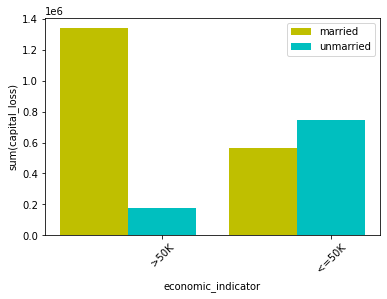

Dimension - relationship, measure - capital_loss, aggregate function - avg


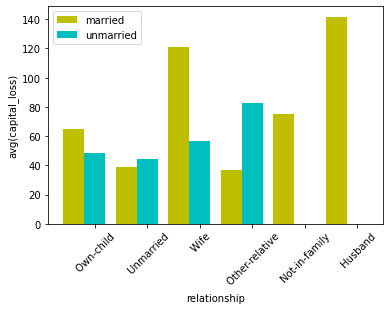

Dimension - relationship, measure - capital_gain, aggregate function - max


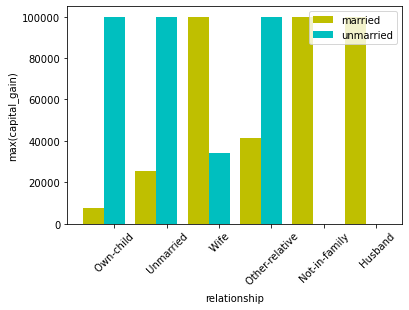

Dimension - economic_indicator, measure - education_num, aggregate function - sum


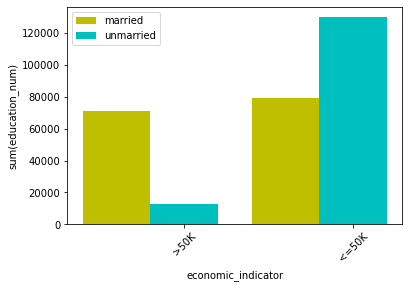

Dimension - relationship, measure - capital_loss, aggregate function - max


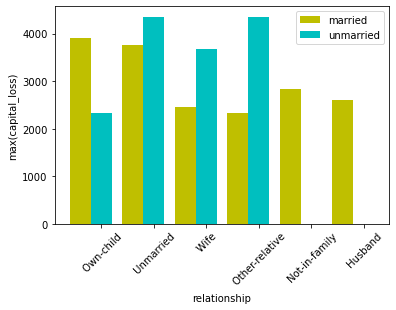

In [117]:
def compute_conf_interval_measure(m, N, delta):
    num_1 = (1-((m-1)/N)) 
    num_2 = (2*np.log(np.log(m))) + np.log((np.pi**2)/(3*delta))
    num = num_1 * num_2
    deno = 2*m
    threshold = np.sqrt(num/deno)
    return threshold

def visualize_k_views(scores, k):
    top_k_view_scores = scores[:k]
    for s in top_k_view_scores:
        f, m, d = total_views[s]
        target_query = "SELECT {}, {}({}) FROM married GROUP BY {};".format(d, f, m, d)
        cur.execute(target_query)
        target_rows = cur.fetchall()
        ref_query = "SELECT {}, {}({}) FROM unmarried GROUP BY {};".format(d, f, m, d)
        cur.execute(ref_query)
        ref_rows = cur.fetchall()
        target_dict = dict(target_rows)
        ref_dict = dict(ref_rows)
        for t in target_dict.keys():
            if t not in ref_dict:
                ref_dict[t] = 0
        for r in ref_dict.keys():
            if r not in target_dict:
                target_dict[r] = 0
        draw_graphs(target_dict, ref_dict, (d, m, f))

def pruning_based_optimization(K=5, phases=10, delta=0.05):
# Implementation of Confidence-Interval based pruning
    view_scores = {key: [] for key, val in total_views.items()}
    current_views = {key: val for key, val in total_views.items()}

    for i in range(1, phases+1):
        partitions = ['s{}_married'.format(i), 's{}_unmarried'.format(i)]
        rows, cols = sharing_based_optimization(views, partitions)
        target_df = pd.DataFrame(rows[0], columns=cols)
        ref_df = pd.DataFrame(rows[1], columns=cols)
        for v, (f, m, a) in current_views.items():
            target = target_df.loc[target_df[a].notnull(), [a, 'v{}'.format(v)]]
            ref = ref_df.loc[ref_df[a].notnull(), [a, 'v{}'.format(v)]]
            joined = target.join(ref.set_index(a), on=a, how="inner", lsuffix='_tgt', rsuffix='_ref')
            tgt_val = joined['v{}_tgt'.format(v)].values
            ref_val = joined['v{}_ref'.format(v)].values
            utility_metric = compute_KL_divergence(tgt_val, ref_val)
            view_scores[v].append(utility_metric)
        if i != 0:
            current_view_scores = []
            conf_threshold = compute_conf_interval_measure(i, phases, delta)
            for l, m in view_scores.items():
                if l in current_views:
                    current_view_scores.append((l, m))
            sorted_view_scores = sorted(current_view_scores, key=lambda x: np.mean(x[1]), reverse=True)
            threshold_lower_bound = np.mean(sorted_view_scores[K][1]) - conf_threshold
            for l, m in view_scores.items():
                if l in current_views and np.mean(m) + conf_threshold < threshold_lower_bound:
                    del current_views[l]
    print('Number of pruned views: {}.'.format(len(total_views)-len(current_views)))
    visualize_k_views([sv[0] for sv in sorted_view_scores], K)
pruning_based_optimization(5, 10, 0.05)

Total number of pruned views: 10.
Dimension - economic_indicator, measure - capital_loss, aggregate function - sum


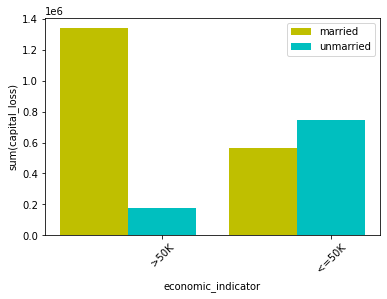

Dimension - relationship, measure - capital_loss, aggregate function - avg


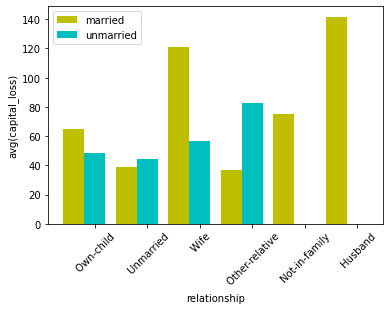

Dimension - relationship, measure - capital_gain, aggregate function - max


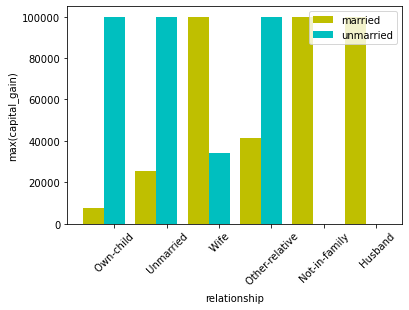

Dimension - economic_indicator, measure - education_num, aggregate function - sum


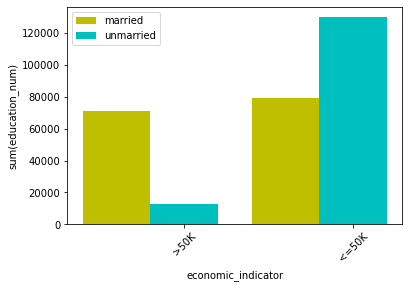

Dimension - relationship, measure - capital_loss, aggregate function - max


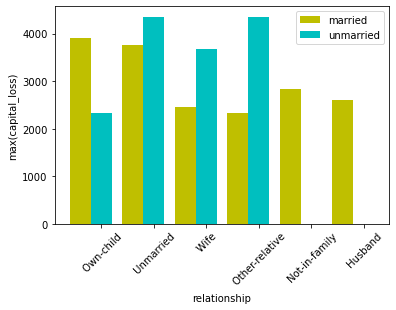

In [123]:
def multi_armed_bandit_pruning(K=5, phases=10):
# Implementation of Multi-Armed bandit pruning
    view_scores = {key: [] for key, val in total_views.items()}
    current_views = {key: val for key, val in total_views.items()}
    interesting_views = []
    for i in range(1, phases+1):
        partitions = ['s{}_married'.format(i), 's{}_unmarried'.format(i)]
        rows, cols = sharing_based_optimization(views, partitions)
        target_df = pd.DataFrame(rows[0], columns=cols)
        ref_df = pd.DataFrame(rows[1], columns=cols)
        for v, (f, m, a) in current_views.items():
            target = target_df.loc[target_df[a].notnull(), [a, 'v{}'.format(v)]]
            ref = ref_df.loc[ref_df[a].notnull(), [a, 'v{}'.format(v)]]
            tmp = target.join(ref.set_index(a), on=a, how="inner", lsuffix='_tgt', rsuffix='_ref')
            tgt_val = tmp['v{}_tgt'.format(v)].values
            ref_val = tmp['v{}_ref'.format(v)].values
            utility_metric = compute_KL_divergence(tgt_val, ref_val)
            view_scores[v].append(utility_metric)
        sorted_view_scores = sorted(view_scores.items(), key=lambda x: np.mean(x[1]), reverse=True)
        d1 = np.mean(sorted_view_scores[0][1]) - np.mean(sorted_view_scores[K+1][1])
        dn = np.mean(sorted_view_scores[K][1]) - np.mean(sorted_view_scores[-1][1])
        if d1 < dn:
            del current_views[sorted_view_scores[-1][0]]
            del view_scores[sorted_view_scores[-1][0]]
        else:
            interesting_views.append(sorted_view_scores[0][0])
            del current_views[sorted_view_scores[0][0]]
            del view_scores[sorted_view_scores[0][0]]
            
    print('Total number of pruned views: {}.'.format(len(total_views)-len(current_views)))
    visualize_k_views(interesting_views + [sv[0] for sv in sorted_view_scores], K)
multi_armed_bandit_pruning(K=5, phases=10)